# Machine translation using RNN
The code is taken from [PyTorch examples](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html)

![](https://pytorch.org/tutorials/_images/seq2seq.png)

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata



import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {} # 
        self.word2count = {} # words counter
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS


    def addSentence(self, sentence):
        # Add words splitting the sentence by space
        ### BEGIN SOLUTION
        for word in sentence.split(' '):
            self.addWord(word)
        ### END SOLUTION
    
    def addWord(self, word):
        # Update self.word2index, self.word2count, self.n_words
        ### BEGIN SOLUTION
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
        ### END SOLUTION

In [3]:
test_lang = Lang('test')
test_lang.addSentence('Hello, World!')
assert test_lang.n_words == 4
assert test_lang.word2index == {'Hello,': 2, 'World!': 3}
assert test_lang.word2count == {'Hello,': 1, 'World!': 1}

In [4]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [5]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [6]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [7]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

# Uncomment if data does not exists
# !wget https://download.pytorch.org/tutorial/data.zip
# !unzip data.zip > /dev/null

input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...


Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803
['tu n es pas invitee .', 'you aren t invited .']


In [8]:
def indexesFromSentence(lang, sentence):
    # split sentence by space and convert words to indices
    ### BEGIN SOLUTION
    return [lang.word2index[word] for word in sentence.split(' ')]
    ### END SOLUTION


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [9]:
assert indexesFromSentence(output_lang, 'master driver') == [975, 977]

In [10]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size) # Special learnable layer which converts tensor of word indices to tensor of hidden size
        # Define your RNN here
        ### BEGIN SOLUTION
        self.gru = nn.GRU(hidden_size, hidden_size)
        ### END SOLUTION

    def forward(self, input, hidden):
        # HINT 1: input is single sentence of word indexes
        # HINT 2: PyTorch RNNs takes [seq_len, batch_size, hidden_size] tensor as input
        ### BEGIN SOLUTION
        embedded = self.embedding(input).view(-1, 1, self.hidden_size)
        output = embedded
        output, hidden = self.gru(output, hidden)
        ### END SOLUTION
        return output, hidden

    def initHidden(self):

        return torch.zeros(1, 1, self.hidden_size, device=device)

In [11]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        ### BEGIN SOLUTION
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        ### END SOLUTION

    def forward(self, input, hidden):
        ### BEGIN SOLUTION
        output = self.embedding(input).view(-1, 1, self.hidden_size)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        ### END SOLUTION
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [12]:
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH,teacher_forcing_ratio=0.5):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    for di in range(target_length):
        decoder_output, decoder_hidden = decoder(
            decoder_input, decoder_hidden)
        if use_teacher_forcing: # Teacher forcing: Feed the target as the next decoder input
            ### BEGIN SOLUTION
            decoder_input = target_tensor[di]  # Teacher forcing
            ### END SOLUTION
        else:                   # Without teacher forcing: use its own predictions as the next input
            ### BEGIN SOLUTION
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as decoder input
            ### END SOLUTION
        loss += criterion(decoder_output, target_tensor[di])
        # Stop if terminate token (EOS) is generated
        ### BEGIN SOLUTION
        if decoder_input.item() == EOS_token: # Terminate token is returned. Stop
            break
        ### END SOLUTION

    # Perform gradient step
    ### BEGIN SOLUTION
    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()
    ### END SOLUTION
    
    return loss.item() / target_length

In [13]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [14]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)


In [15]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [16]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()


        decoded_words = []
        # Translate the sentence. Substitute EOS_token with "<EOS>" and append to the end of decoded_words
        
        ### BEGIN SOLUTION
        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        ### END SOLUTION
        return decoded_words

In [17]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

1m 20s (- 18m 42s) (5000 6%) 2.8946


2m 33s (- 16m 37s) (10000 13%) 2.3621


3m 45s (- 15m 0s) (15000 20%) 2.0436


4m 58s (- 13m 41s) (20000 26%) 1.7838


6m 12s (- 12m 25s) (25000 33%) 1.5733


7m 27s (- 11m 10s) (30000 40%) 1.3990


8m 40s (- 9m 55s) (35000 46%) 1.2371


9m 55s (- 8m 40s) (40000 53%) 1.1160


11m 8s (- 7m 25s) (45000 60%) 0.9719


12m 21s (- 6m 10s) (50000 66%) 0.8853


13m 33s (- 4m 55s) (55000 73%) 0.7799


14m 47s (- 3m 41s) (60000 80%) 0.7109


16m 0s (- 2m 27s) (65000 86%) 0.6240


17m 13s (- 1m 13s) (70000 93%) 0.5805


18m 28s (- 0m 0s) (75000 100%) 0.5099


<Figure size 432x288 with 0 Axes>

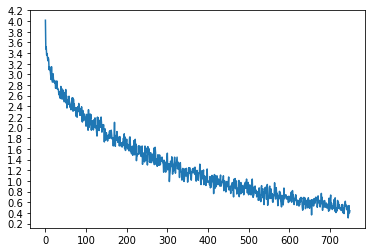

In [18]:
hidden_size = 256
encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = DecoderRNN(hidden_size, output_lang.n_words).to(device)

trainIters(encoder, decoder, 75000, print_every=5000)

In [19]:
evaluateRandomly(encoder, decoder)

> c est un romancier et un artiste .
= he is a novelist and artist .
< he is a novelist and artist . <EOS>

> je ne suis pas folle .
= i m not insane .
< i m not mad . <EOS>

> ce ne sont pas mes amis .
= they re not my friends .
< they re not my friends . <EOS>

> c est vous l instituteur .
= you re the teacher .
< you re the teacher . <EOS>

> je suis fiere de vous les mecs .
= i m proud of you guys .
< i m proud of you guys you . <EOS>

> je ne suis plus mariee avec tom .
= i m not married to tom anymore .
< i m not married to tom anymore . <EOS>

> elles sont toutes normales .
= they re all normal .
< they re all normal . <EOS>

> j en ai marre d elle .
= i m fed up with her .
< i m tired of her . <EOS>

> il est bon en anglais .
= he is a good speaker of english .
< he is good at english . <EOS>

> vous etes ruses .
= you re crafty .
< you re crafty . <EOS>



In [20]:
### BEGIN HIDDEN TESTS
res = []
for pair in pairs[:40]:
    output_words = evaluate(encoder, decoder, pair[0])
    res.append(output_words == pair[1].split(' ') + ['<EOS>'])
assert np.mean(res) > 0.55
### END HIDDEN TESTS